In [1]:
import numpy as np
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/data/long_run_310k.npy')

psi = psi[:, 0, :]
print(psi.shape)

mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi


psi_val= psi[210000:270000, :]
psi = psi[0:300000, :]

print(psi_val.shape)
print(psi.shape)

(309700, 75)
(60000, 75)
(300000, 75)


In [3]:
# Pre-processing


num_of_prev_t = 20
lead = 1

trainN = 200000
valN = 50000
index = 63


#Training Data
psi_train_input = torch.tensor(psi[num_of_prev_t : trainN + num_of_prev_t,:]) #Has to increase by n-time steps more than memory size 
psi_train_label =  torch.tensor(psi[num_of_prev_t + lead : trainN + lead + num_of_prev_t,:])
psi_torch = torch.as_tensor(psi, dtype=torch.float16)
psi_memory = (psi_torch.unfold(dimension=0, size=num_of_prev_t, step=1)[:trainN].reshape(trainN, -1))
print("Train input: ", psi_train_input.shape)
print("Train label: ", psi_train_label.shape)
print("Memory: ", psi_memory.shape)

#Validation Data
psi_val_input = torch.tensor(psi_val[num_of_prev_t : valN + num_of_prev_t, :])
psi_val_label =  torch.tensor(psi_val[num_of_prev_t + lead : valN + num_of_prev_t + lead, :])
psi_val_torch = torch.as_tensor(psi_val, dtype=torch.float32)
psi_memory_val = (psi_val_torch.unfold(dimension=0, size=num_of_prev_t, step=1)[:valN].reshape(valN, -1))
print("Train input: ", psi_train_input.shape)
print("Validation label ", psi_val_label.shape)
print("Val Memory: ", psi_memory_val.shape)


# #actual implementation
# pred_hist, _ = np.histogram(predictions, bins=50, density=True)
# actual_hist, _ = np.histogram(actual_values,bins=50,density=True)

# tvd = total_variation_distance(pred_hist,actual_hist)


Train input:  torch.Size([200000, 75])
Train label:  torch.Size([200000, 75])
Memory:  torch.Size([200000, 1500])
Train input:  torch.Size([200000, 75])
Validation label  torch.Size([50000, 75])
Val Memory:  torch.Size([50000, 1500])


(300000, 75)


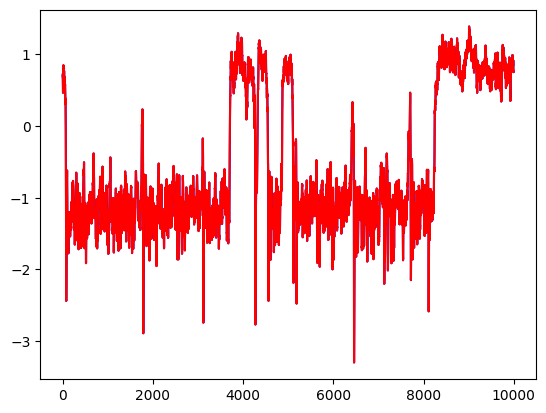

In [4]:
print(psi.shape)
# plt.plot(psi_train_input[0:200000,63])
plt.plot(psi_train_input[0:10000,63], color="blue")
plt.plot(psi_train_label[0:10000, 63], color="red")


In [6]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        # self.fc1 = nn.Linear(input_dim, 512)  
        # self.fc2 = nn.Linear(512, 512)  
        # self.fc3 = nn.Linear(512, 512)  
        # self.fc4 = nn.Linear(512, 512)  
        # self.fc5 = nn.Linear(512, 512)  
        # self.fc6 = nn.Linear(512, 512)  
        # self.fc_mu = nn.Linear(512, latent_dim)  
        # self.fc_logvar = nn.Linear(512, latent_dim)  

    def forward(self, x):
        # x = torch.relu(self.fc1(x)) # Activation function for hidden layer
        # x = torch.relu(self.fc2(x)) + x
        # x = torch.relu(self.fc3(x)) + x
        # x = torch.relu(self.fc4(x)) + x
        # mu = self.fc_mu(x)
        # logvar = self.fc_logvar(x)
        # return mu, logvar
        return None

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, prev_elem):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim + prev_elem, 512)  
        self.fc2 = nn.Linear(512, 512) 
        self.fc3 = nn.Linear(512, 512) 
        self.fc4 = nn.Linear(512, 512)         
        self.fc5 = nn.Linear(512, 512)  
        self.fc6 = nn.Linear(512, 512)  
        self.fc_output = nn.Linear(512, output_dim) 

    def forward(self, z, input_val, prev_element):
        """"
        z = latent_space 
        input_val = is the input value in batches
        prev_element = the previous elements
        """
        z = torch.cat((z, input_val), dim=1)  # Concatenate latent vector and condition 
        z = torch.cat((z, prev_element), dim = 1)
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim, prev_elem):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, prev_elem)

    # def encode(self, x):
    #     mu, logvar = self.encoder(x)
    #     return mu, logvar

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     z = mu + eps * std
    #     return z

    def decode(self, z, condition, prev_elem):
        return self.decoder(z, condition, prev_elem)

#When model() is called this function is called.
    def forward(self, z, input_val, prev_elem):
        z = torch.randn(z.size(0), z.size(1)).to(z.device)  # Sample from standard normal distribution
        # latent_space = torch.randn(latent_space.size(0), latent_space(1)).to(latent_space.device) 
        output = self.decode(z, input_val, prev_elem)
        # return output, mu, logvar
        return output


Epoch 1,Reconstrunction Loss: 1822.289306640625
Validation Reconstrunction Loss: 5614.90625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


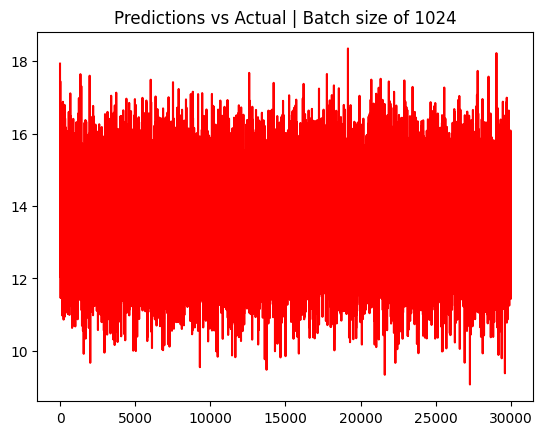

Epoch 2,Reconstrunction Loss: 1165.8427734375
Validation Reconstrunction Loss: 2887.3876953125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


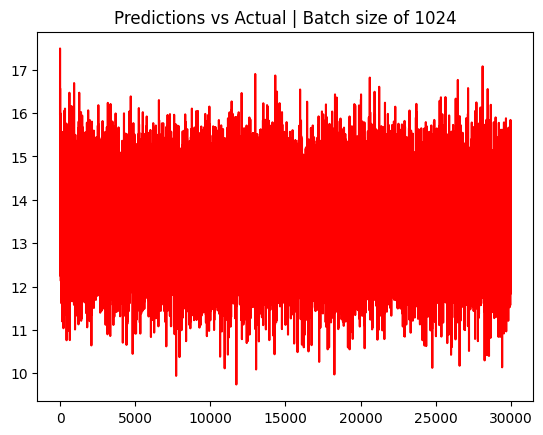

Epoch 3,Reconstrunction Loss: 871.2697143554688
Validation Reconstrunction Loss: 1986.447998046875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


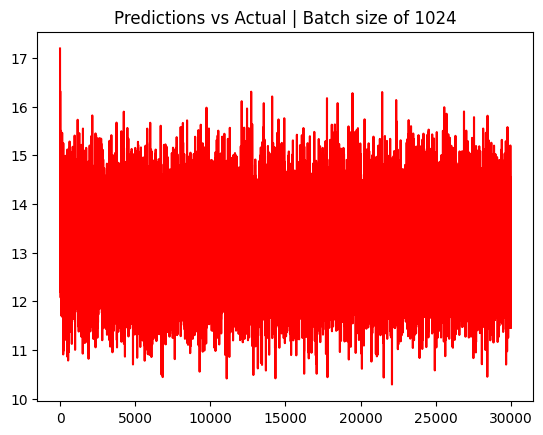

Epoch 4,Reconstrunction Loss: 731.9195556640625
Validation Reconstrunction Loss: 1749.79052734375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


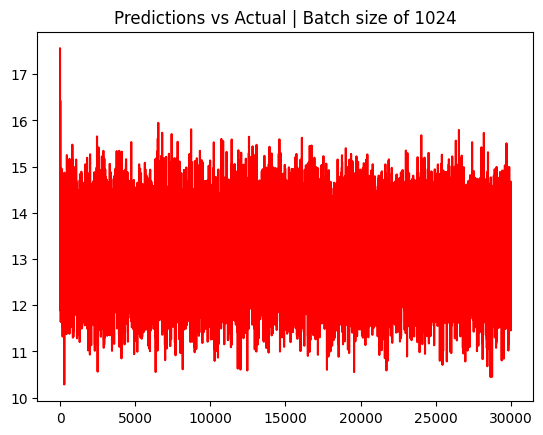

Epoch 5,Reconstrunction Loss: 569.285888671875
Validation Reconstrunction Loss: 1373.568359375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


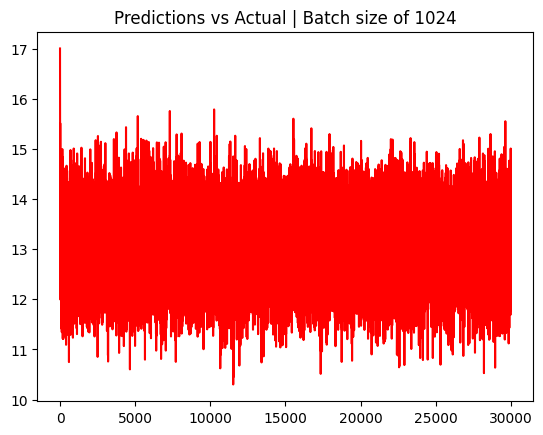

Epoch 6,Reconstrunction Loss: 505.703369140625
Validation Reconstrunction Loss: 1291.1419677734375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


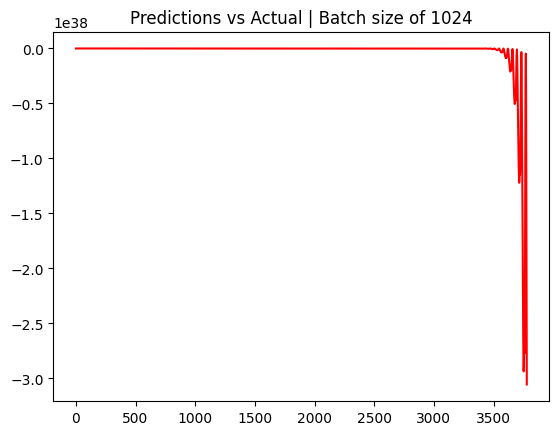

Epoch 7,Reconstrunction Loss: 443.98358154296875
Validation Reconstrunction Loss: 1182.440673828125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


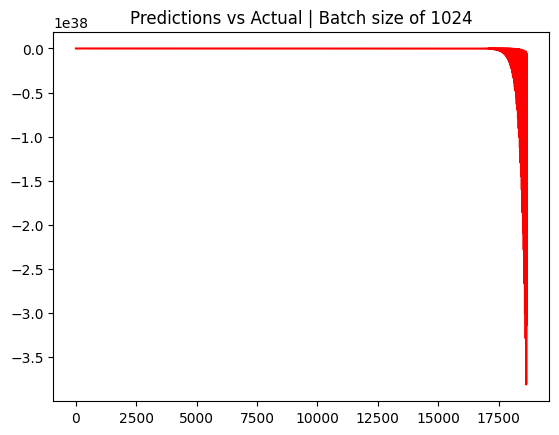

Epoch 8,Reconstrunction Loss: 376.5572814941406
Validation Reconstrunction Loss: 1022.0211181640625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


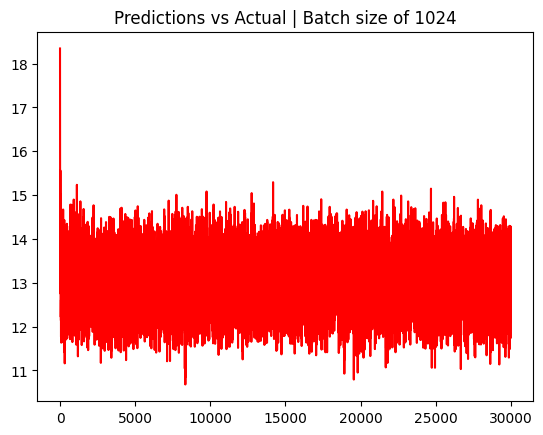

Epoch 9,Reconstrunction Loss: 341.67596435546875
Validation Reconstrunction Loss: 979.4886474609375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


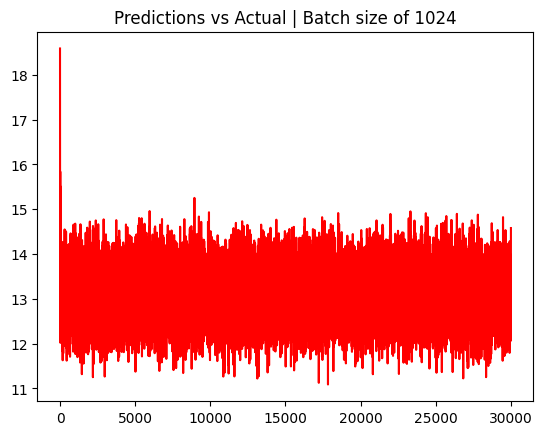

Epoch 10,Reconstrunction Loss: 314.100830078125
Validation Reconstrunction Loss: 951.4239501953125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


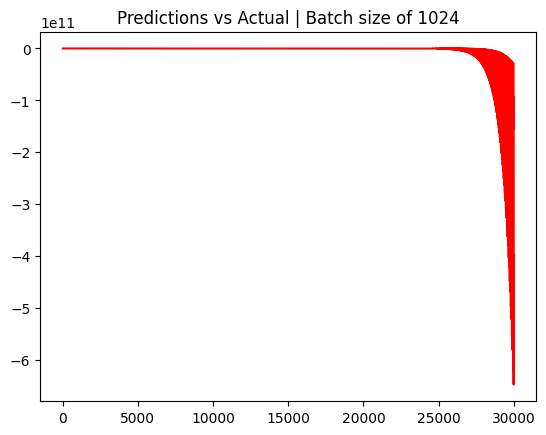

Epoch 11,Reconstrunction Loss: 289.4578857421875
Validation Reconstrunction Loss: 831.7444458007812 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


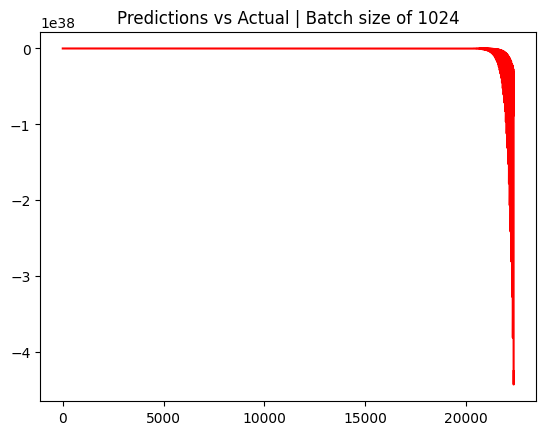

Epoch 12,Reconstrunction Loss: 286.5615234375
Validation Reconstrunction Loss: 756.52685546875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


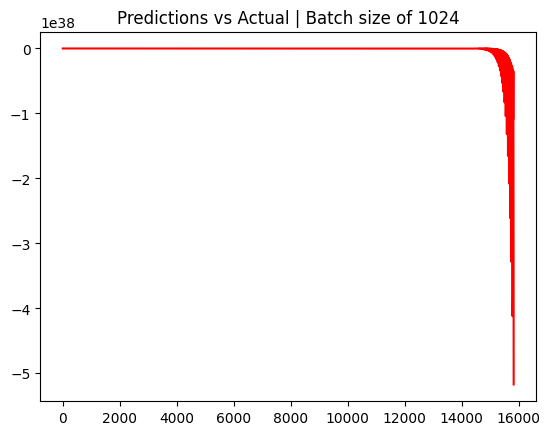

Epoch 13,Reconstrunction Loss: 257.82958984375
Validation Reconstrunction Loss: 762.3511352539062 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


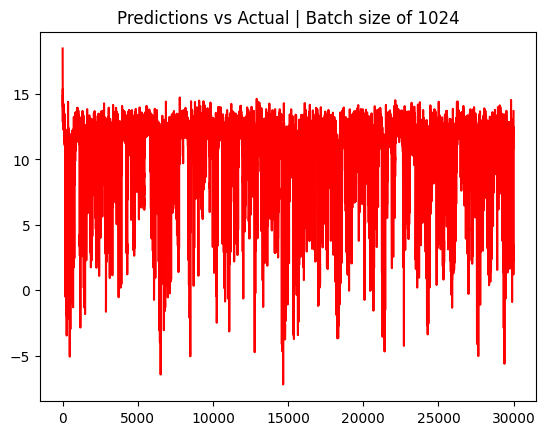

Epoch 14,Reconstrunction Loss: 235.42572021484375
Validation Reconstrunction Loss: 710.4989624023438 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


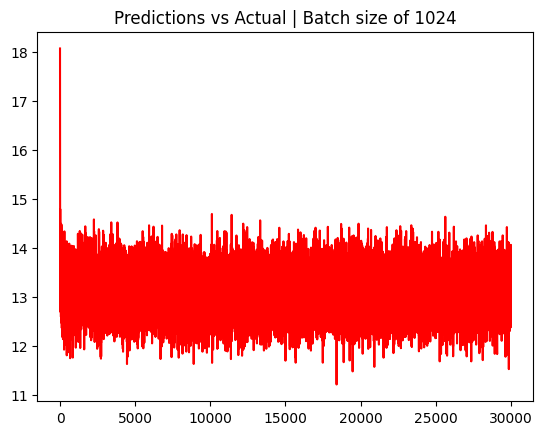

Epoch 15,Reconstrunction Loss: 234.67372131347656
Validation Reconstrunction Loss: 699.7901611328125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


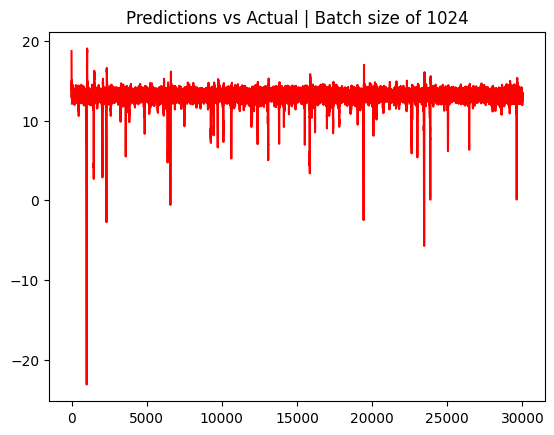

Epoch 16,Reconstrunction Loss: 211.44049072265625
Validation Reconstrunction Loss: 609.727783203125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


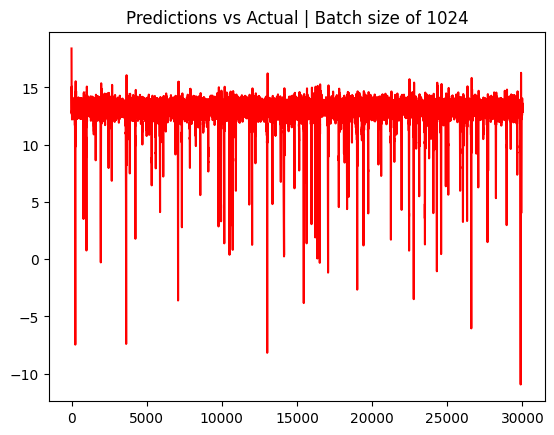

Epoch 17,Reconstrunction Loss: 207.73760986328125
Validation Reconstrunction Loss: 660.9058837890625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


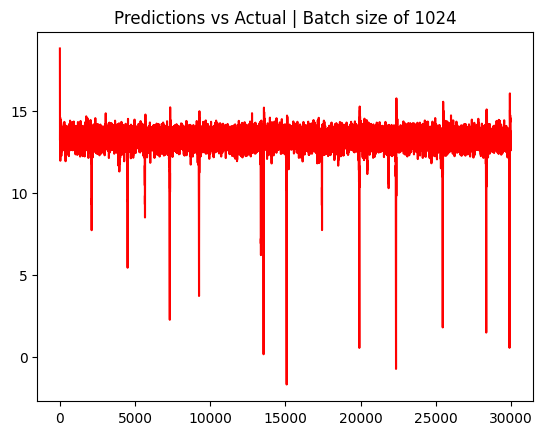

Epoch 18,Reconstrunction Loss: 201.6659393310547
Validation Reconstrunction Loss: 577.0054931640625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


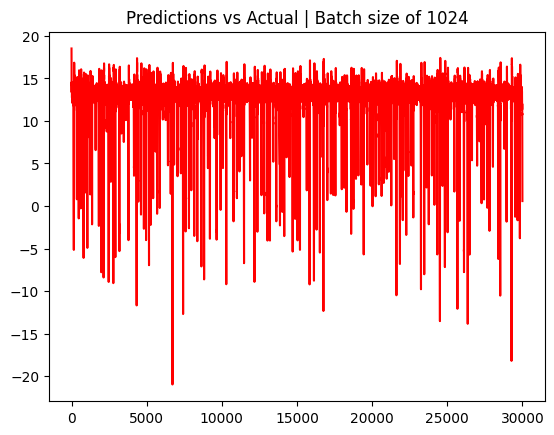

Epoch 19,Reconstrunction Loss: 191.85418701171875
Validation Reconstrunction Loss: 597.0667724609375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


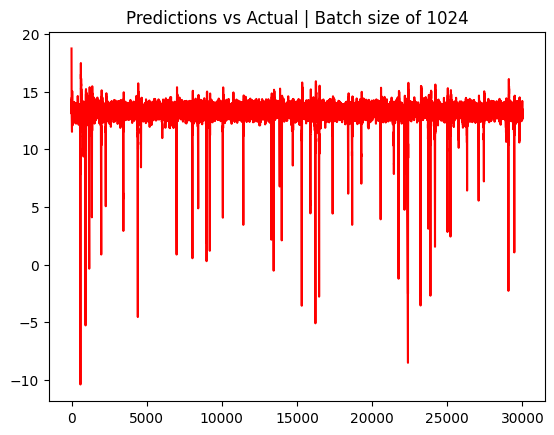

Epoch 20,Reconstrunction Loss: 190.47268676757812
Validation Reconstrunction Loss: 562.2216796875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


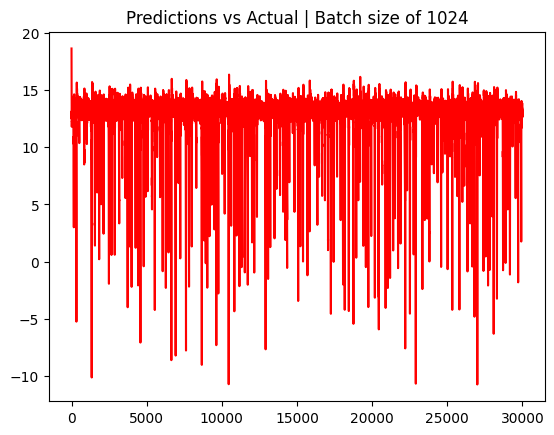

Epoch 21,Reconstrunction Loss: 189.6704559326172
Validation Reconstrunction Loss: 547.8990478515625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


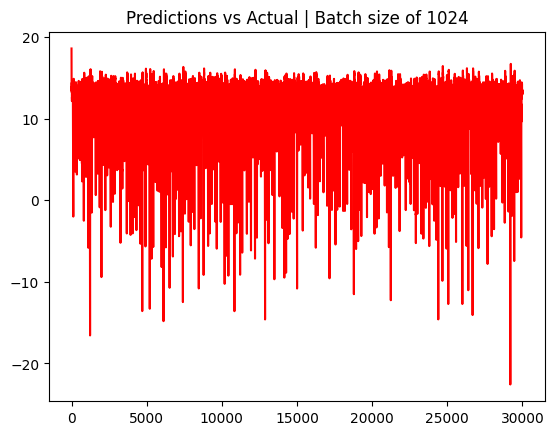

Epoch 22,Reconstrunction Loss: 188.29286193847656
Validation Reconstrunction Loss: 588.9684448242188 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


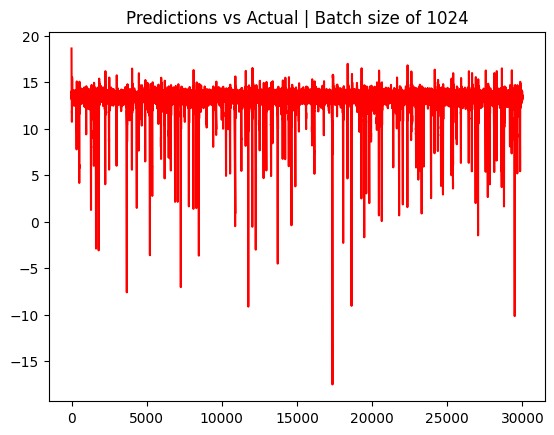

Epoch 23,Reconstrunction Loss: 180.97247314453125
Validation Reconstrunction Loss: 561.7716064453125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


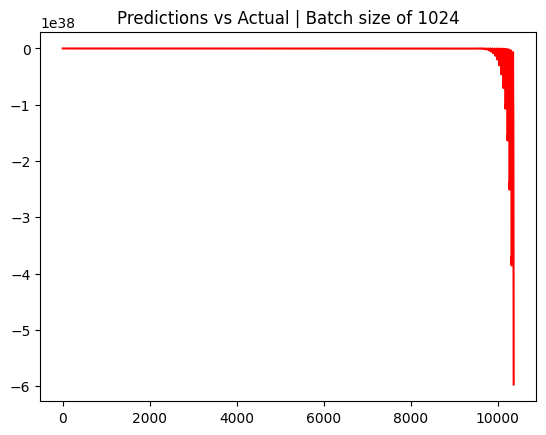

Epoch 24,Reconstrunction Loss: 172.52967834472656
Validation Reconstrunction Loss: 519.5765380859375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


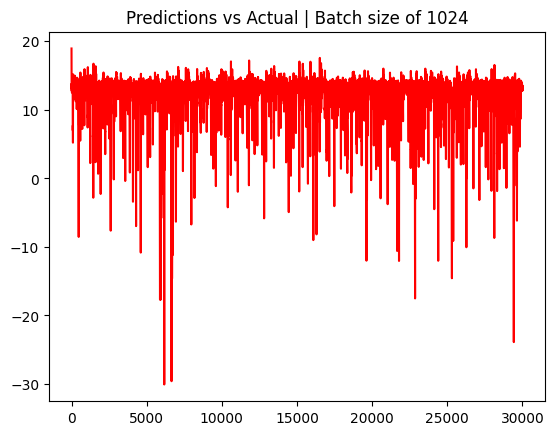

Epoch 25,Reconstrunction Loss: 176.87693786621094
Validation Reconstrunction Loss: 556.938720703125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


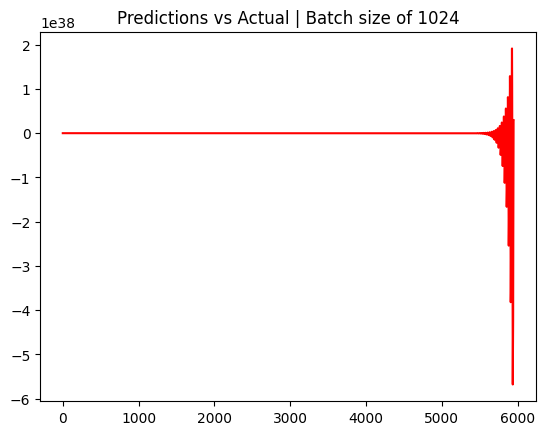

Epoch 26,Reconstrunction Loss: 179.2010498046875
Validation Reconstrunction Loss: 508.3260498046875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


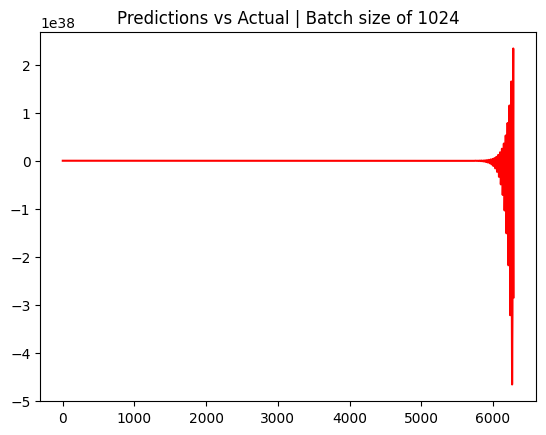

Epoch 27,Reconstrunction Loss: 175.259765625
Validation Reconstrunction Loss: 526.5528564453125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


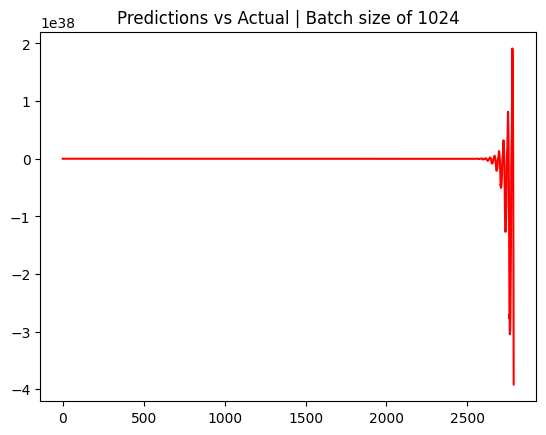

Epoch 28,Reconstrunction Loss: 172.8072052001953
Validation Reconstrunction Loss: 596.3132934570312 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


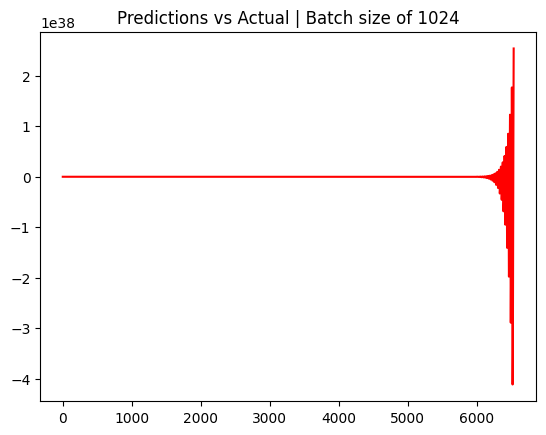

Epoch 29,Reconstrunction Loss: 165.6809539794922
Validation Reconstrunction Loss: 510.97613525390625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


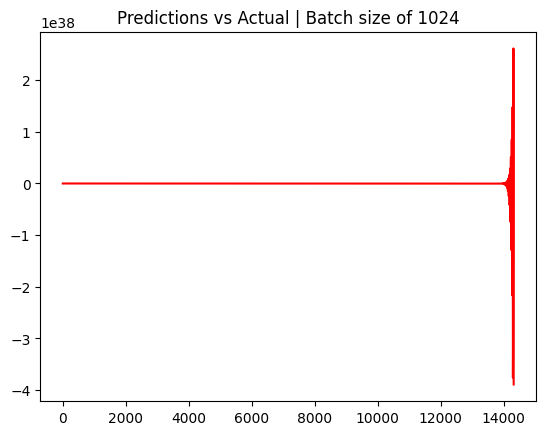

Epoch 30,Reconstrunction Loss: 172.0646514892578
Validation Reconstrunction Loss: 506.0332946777344 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


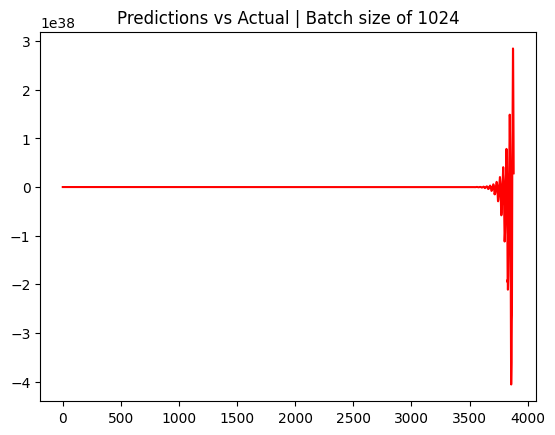

Epoch 31,Reconstrunction Loss: 162.0898895263672
Validation Reconstrunction Loss: 507.02789306640625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


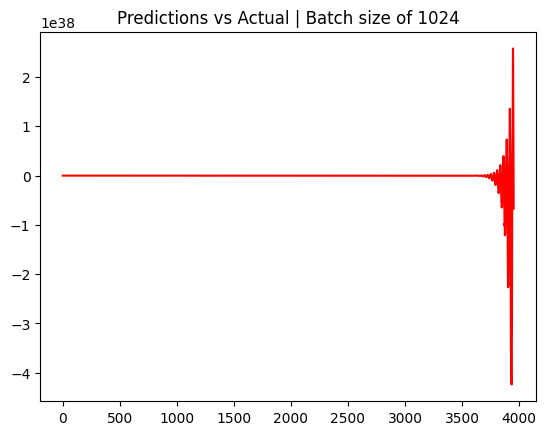

Epoch 32,Reconstrunction Loss: 165.55609130859375
Validation Reconstrunction Loss: 500.9060974121094 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


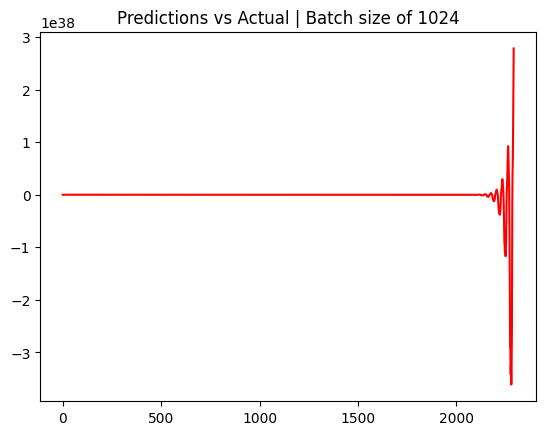

Epoch 33,Reconstrunction Loss: 161.59127807617188
Validation Reconstrunction Loss: 494.398193359375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


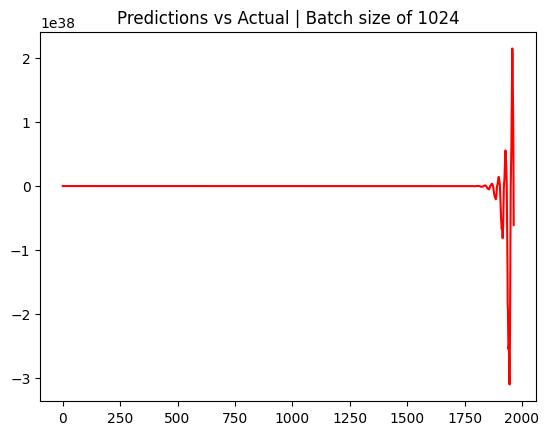

Epoch 34,Reconstrunction Loss: 160.0343780517578
Validation Reconstrunction Loss: 479.4691162109375 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


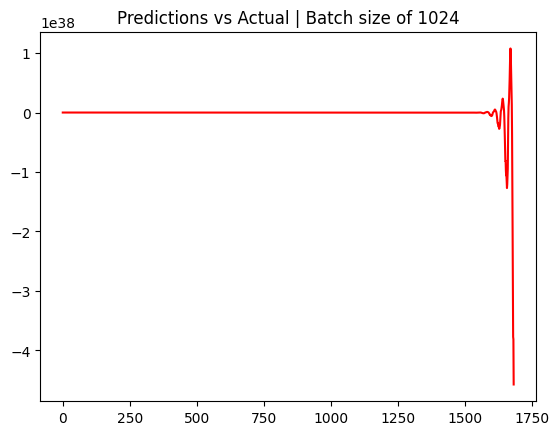

Epoch 35,Reconstrunction Loss: 179.38319396972656
Validation Reconstrunction Loss: 625.60546875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


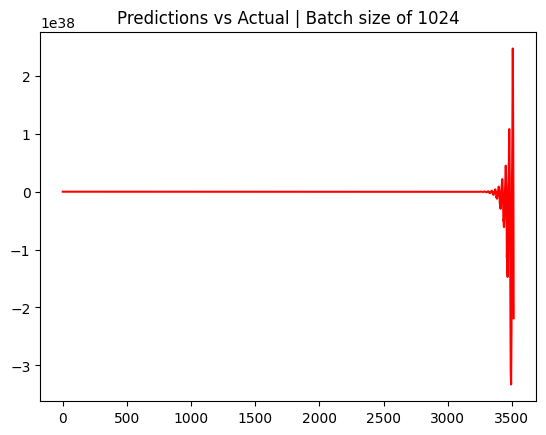

Epoch 36,Reconstrunction Loss: 174.7767333984375
Validation Reconstrunction Loss: 508.9980773925781 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


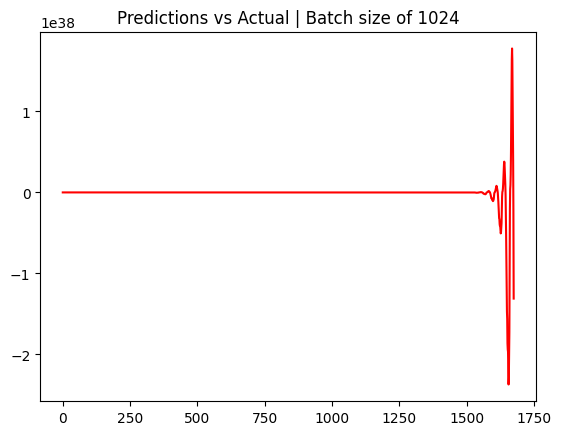

Epoch 37,Reconstrunction Loss: 156.419921875
Validation Reconstrunction Loss: 450.05548095703125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


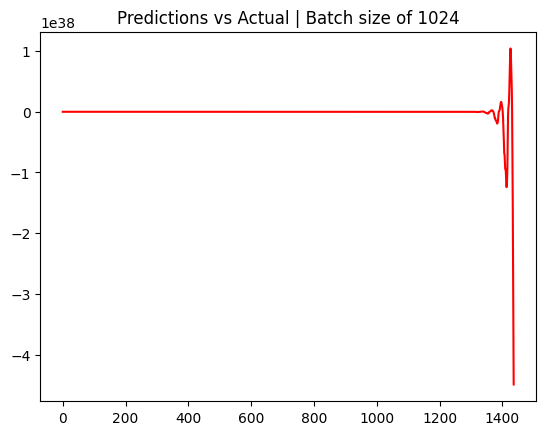

Epoch 38,Reconstrunction Loss: 152.47610473632812
Validation Reconstrunction Loss: 464.44195556640625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


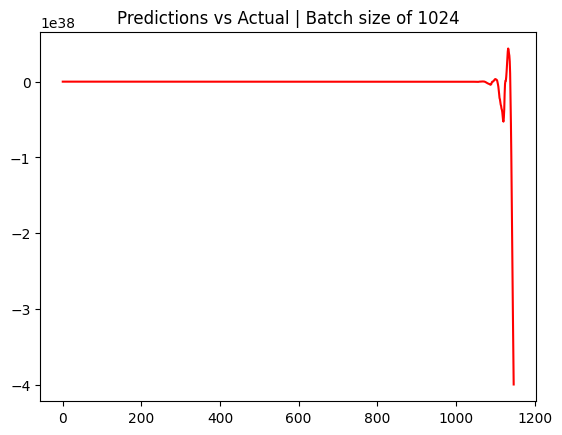

Epoch 39,Reconstrunction Loss: 160.04067993164062
Validation Reconstrunction Loss: 513.0868530273438 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


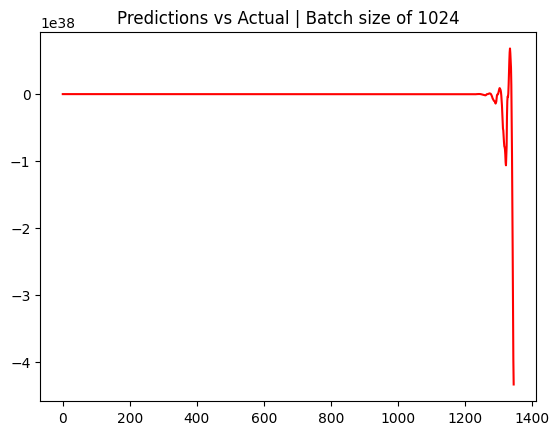

Epoch 40,Reconstrunction Loss: 154.61715698242188
Validation Reconstrunction Loss: 442.77606201171875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


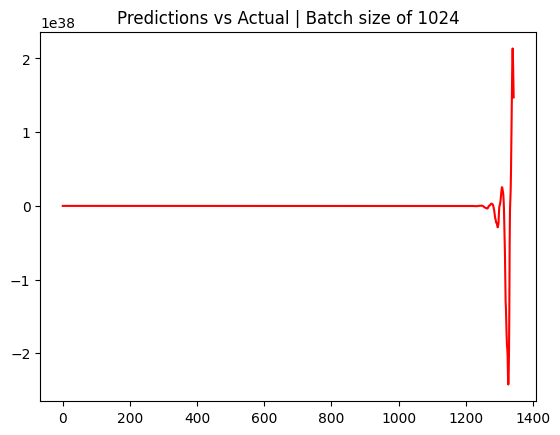

Epoch 41,Reconstrunction Loss: 151.2988739013672
Validation Reconstrunction Loss: 443.4588928222656 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


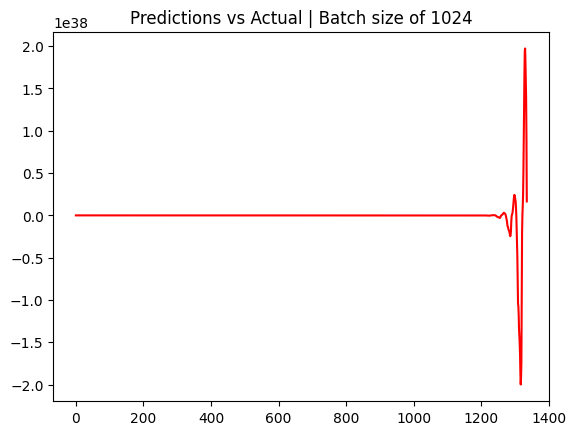

Epoch 42,Reconstrunction Loss: 146.99029541015625
Validation Reconstrunction Loss: 434.49151611328125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


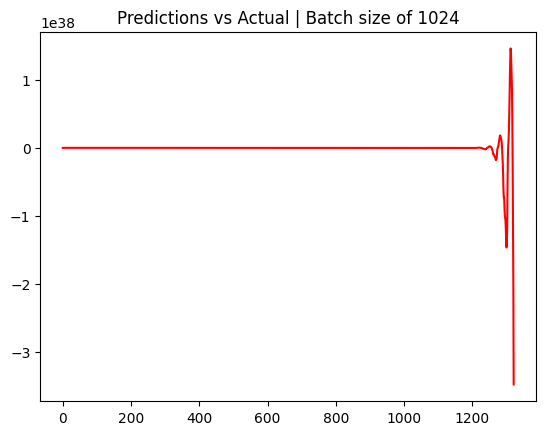

Epoch 43,Reconstrunction Loss: 153.44720458984375
Validation Reconstrunction Loss: 483.54864501953125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


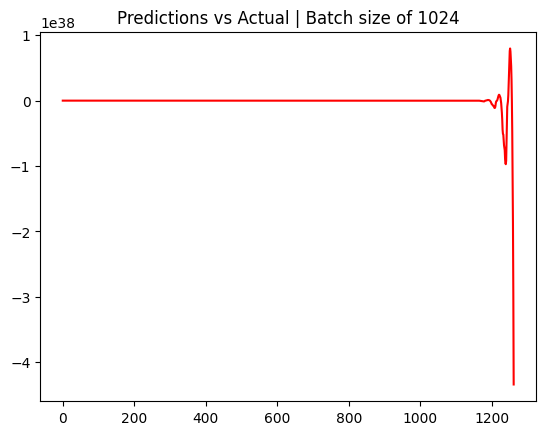

Epoch 44,Reconstrunction Loss: 154.20529174804688
Validation Reconstrunction Loss: 469.19244384765625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


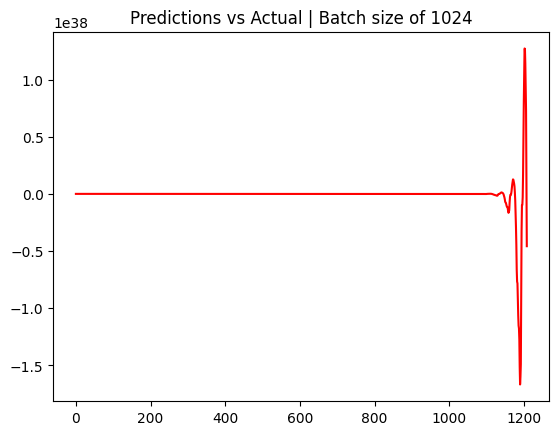

Epoch 45,Reconstrunction Loss: 144.31651306152344
Validation Reconstrunction Loss: 439.7862548828125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


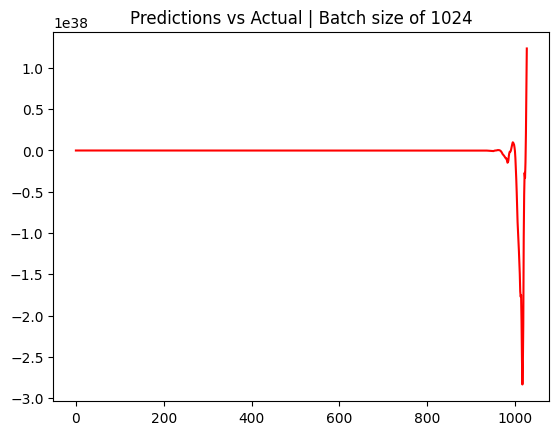

Epoch 46,Reconstrunction Loss: 150.2740478515625
Validation Reconstrunction Loss: 504.00421142578125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


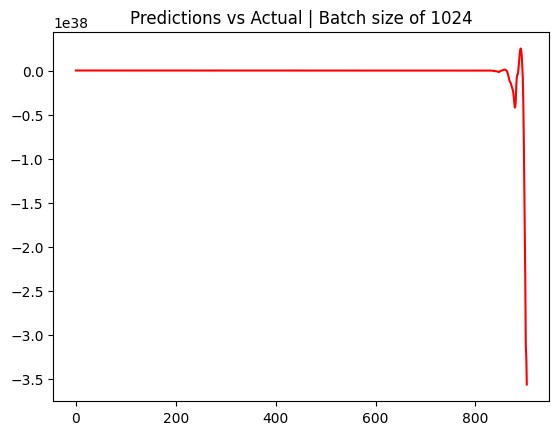

Epoch 47,Reconstrunction Loss: 140.95944213867188
Validation Reconstrunction Loss: 426.1671142578125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


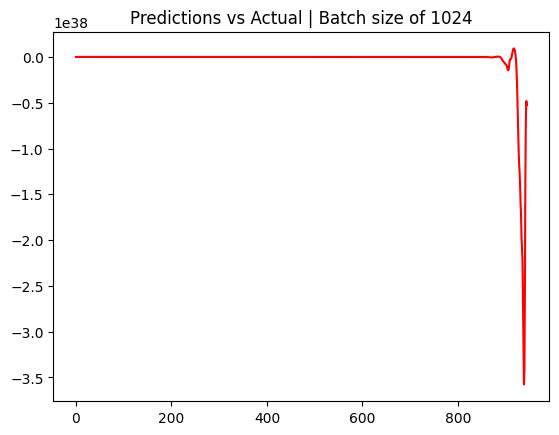

Epoch 48,Reconstrunction Loss: 149.33152770996094
Validation Reconstrunction Loss: 461.7313232421875 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


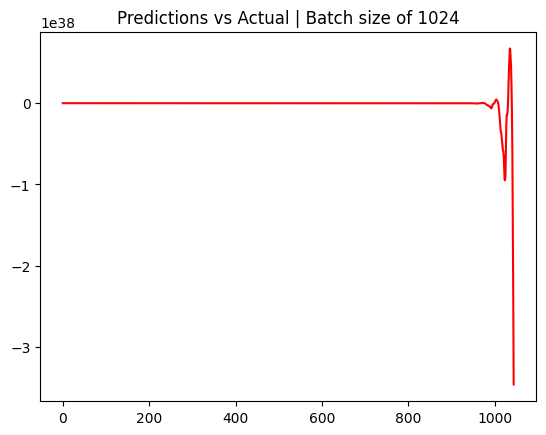

Epoch 49,Reconstrunction Loss: 156.90090942382812
Validation Reconstrunction Loss: 418.7540283203125 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


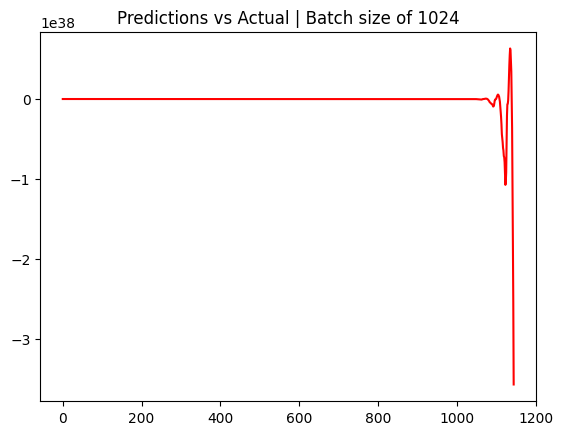

Epoch 50,Reconstrunction Loss: 159.92071533203125
Validation Reconstrunction Loss: 556.373291015625 
[10.48822671]
tensor([21.7374, 21.1385, 20.5833,  ..., -6.0927, -5.0672, -3.8194],
       dtype=torch.float64)


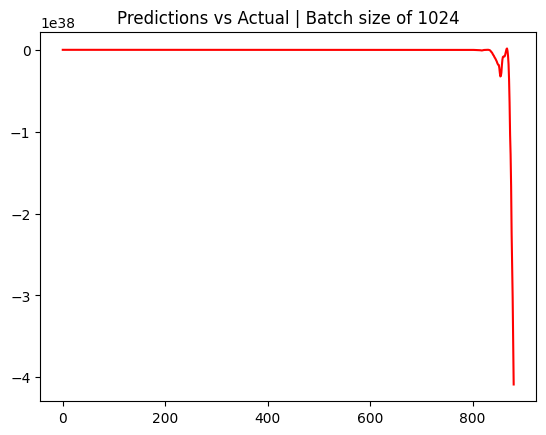

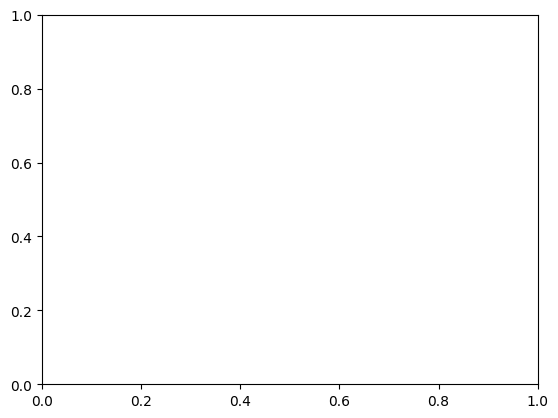

In [7]:
TRAIN_N   = 200_000
VAL_N     = 50_000
number_of_prev_t = num_of_prev_t #Also change in the preprocessing step up above
input_dim = 75
output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 50
prev_elem = 75 * number_of_prev_t

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim, prev_elem)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



def roll_memory(memory_row: torch.Tensor, new_state: torch.Tensor, n_prev: int) -> torch.Tensor:
    """
    memory_row : (1, n_prev*75)  – flattened window [x(t‑n_prev), …, x(t‑1)]
    new_state  : (1, 75)         – x(t) just produced
    returns    : (1, n_prev*75)  – flattened window [x(t‑n_prev+1), …, x(t)]
    """
    # reshape → (1, n_prev, 75), drop the oldest slice, append new_state, flatten again
    mem_3d = memory_row.view(1, n_prev, 75)
    mem_new = torch.cat([mem_3d[:, 1:, :], new_state.unsqueeze(1)], dim=1)
    return mem_new.reshape(1, -1)

for epoch in range(num_epochs):
    z_train = torch.zeros([batch_size, latent_dim])
    z_val = torch.zeros([batch_size, latent_dim])
    model.train()
    for batch in range (0, TRAIN_N, batch_size):

        ### Changed here to include the previous element in batching samples
        prev_element = psi_memory[batch:batch + batch_size,:]

        input_batch = psi_train_input[batch:batch + batch_size,:]
        label_batch = psi_train_label[batch:batch + batch_size,:]
        optimizer.zero_grad()
        z_train = torch.rand_like(z_train)
        z_train = z_train[:input_batch.shape[0],:]


        # output = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())
        output = model(z_train.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())


        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        loss = reconstruction_loss

        loss.backward()
        optimizer.step()

    print(f'''Epoch {epoch+1},Reconstrunction Loss: {reconstruction_loss.item()}''')


    # Validation Loss
    for batch in range (0, VAL_N, batch_size):
        
        prev_element = psi_memory_val[batch:batch + batch_size,:]
        input_batch = psi_val_input[batch:batch + batch_size,:]
        label_batch = psi_val_label[batch:batch + batch_size,:]
        
        z_val = torch.rand_like(z_val)
        z_val = z_val[:input_batch.shape[0],:]

        output = model(z_val.float().cuda() ,input_batch.float().cuda(), prev_element.float().cuda())
        val_reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")

        val_loss = val_reconstruction_loss # Experiment HIGHER coefficients

    print(f'''Validation Reconstrunction Loss: {val_reconstruction_loss.item()} ''')

    initial_cond = torch.reshape(torch.tensor(psi[1,:]), [1, 75])
    t0 = num_of_prev_t
    psi_torch = torch.as_tensor(psi, dtype=torch.float32)
    initial_cond = psi_torch[t0].unsqueeze(0)            

    # sliding window of x(t‑1) … x(t‑num_of_prev_t)
    history = psi_torch[t0 - num_of_prev_t : t0]              
    history_flat = history.reshape(1, -1)
    preveious_elem = history_flat
    time_step = 30000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])
    for k in range (0, time_step):
        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(), initial_cond.float().cuda(), preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                new_state = torch.tensor((y_denorm - mean_psi)/ std_psi)
                preveious_elem = roll_memory(preveious_elem, new_state, num_of_prev_t)
                initial_cond = new_state
    
            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                input_element = torch.reshape(torch.tensor(pred[k-1,:,select_ens]), [1,75]).float().cuda()
                y = (model.decode(z.float().cuda(), input_element, preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                new_state = torch.tensor((y_denorm - mean_psi) / std_psi)
                preveious_elem = roll_memory(preveious_elem, new_state, num_of_prev_t)
                initial_cond = new_state

    # Denormalize final preds
    print(std_psi[:, 63])
    pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

    # Denormalize test labels
    actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
    print(actual_values)

    plt.plot(pred_mean[0:30000,63],'r')
    plt.title(f"Predictions vs Actual | Batch size of {batch_size}")
    plt.show()
    plt.cla()